Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_errorbarh).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_errorbarh).”


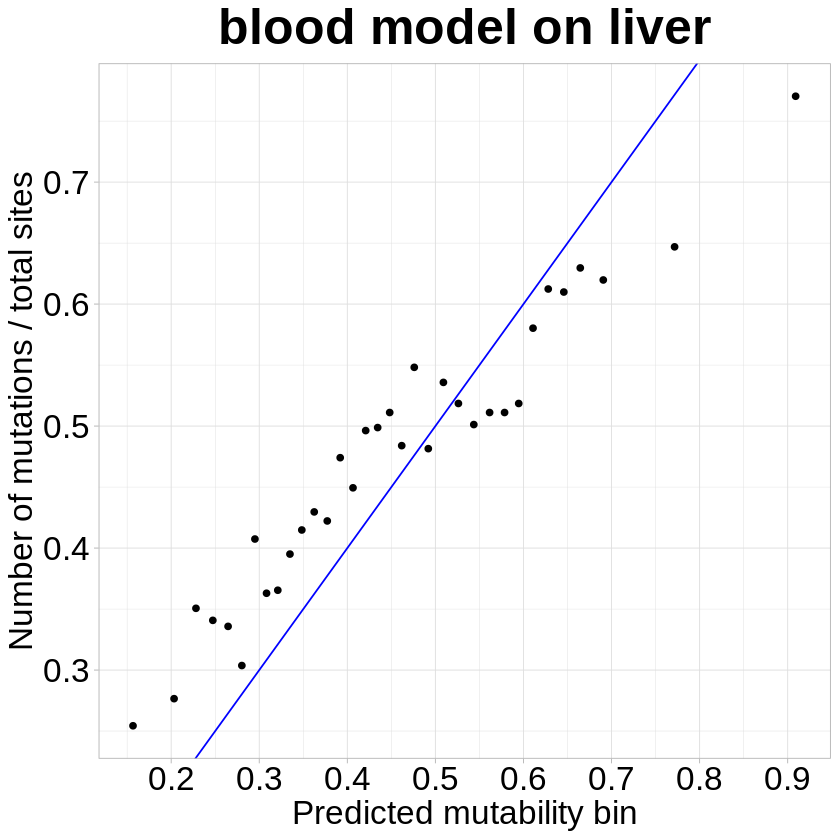

In [1]:
# args = commandArgs(trailingOnly=TRUE)
# model_name = args[1]
# bin_size_desiredMin = as.integer(args[2])
# tissue = args[3]
# tissue_predOn = args[4]
tissue  = "blood"
tissue_predOn = "liver"
model_name = "model4"
bin_size_desiredMin = 400
tmp_pathToFiles = "../../../" #an arbitrary variable i use to convert b/t the directory of the creator notebook (play mode) and the home directory (snakemake executible)

library(ggplot2)
library(stringr)

#getting the tissue values
# tissue = str_extract(prob_df_file_name,"/(liver|skin|blood|germline)")
# tissue= str_remove(tissue,"/")
# tissue_predOn = str_extract(prob_df_file_name,"on_(liver|skin|blood|germline)")
# tissue_predOn = str_remove(tissue_predOn, "on_")

#improting the files 
prob_df_file_path = paste(tmp_pathToFiles,"data/",tissue,"/dataframes/",model_name,"/",tissue,"_on_",tissue_predOn,"_ProbabilityDf.csv",sep="")
probs_df <- read.csv(prob_df_file_path)
error_output_file = paste(tmp_pathToFiles,"analysis/",tissue,"/plots/",model_name,"/",tissue,"_on_",tissue_predOn,"_createPlot_textOutput.txt",sep="")

#sorting df by proabbility 
probs_df_sorted <- probs_df[order(probs_df$glm_probs, decreasing = FALSE),]

#printing some info about the df 
string_to_print = paste("skin on skin: ",sum(probs_df$mutation_status),"muts,",round(sum(probs_df$mutation_status)/nrow(probs_df),2),"ratio",sep=" ")
cat(string_to_print,file=error_output_file,sep="\n")

#making the indexing vectors for plotting ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#creating the bins 
nbin = floor(nrow(probs_df_sorted)/bin_size_desiredMin) #=2
extra_leftover = nrow(probs_df_sorted)-nbin*bin_size_desiredMin #=3
extra_toAddToBins = floor(extra_leftover/nbin)#=1
bin_size = bin_size_desiredMin+extra_toAddToBins
extra_to_add_first_bin = nrow(probs_df_sorted)-(bin_size_desiredMin+extra_toAddToBins)*nbin
stopifnot(extra_to_add_first_bin<=nbin)
string_to_print = paste("to comply with exactly equal bin sizes, sites",bin_size,"to",bin_size+extra_to_add_first_bin,"are ommitted out of",nrow(probs_df),"total sites, with",nbin,"bins sized",bin_size,sep=" ")
cat(string_to_print,file=error_output_file,sep="\n")

#making the vector for plotting 
vector_indexing = c(1, bin_size+extra_to_add_first_bin)
for (i in 1:(nbin-1)){#adjust the finish value so the vector finishes at the nrow of the df 
    vector_indexing <- append(vector_indexing, vector_indexing[i+1]+bin_size)
}
stopifnot(nrow(probs_df_sorted)==tail(vector_indexing,n=1)) #check that the vector finishes at the end of the dataframe

#making the plotting df ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plotting_df <- NULL
for (x in vector_indexing){
    x_end = x+bin_size
    average_predicted_probs = sum(probs_df_sorted$glm_probs[x:x_end])/bin_size
    predicted_probs_sd = sd(probs_df_sorted$glm_probs[x:x_end])
    predicted_probs_sterr = predicted_probs_sd/sqrt(bin_size)
    stderr_lower = average_predicted_probs-predicted_probs_sterr
    stderr_upper = average_predicted_probs+predicted_probs_sterr
    average_proportion_mutations = sum(probs_df_sorted$mutation_status[x:x_end])/bin_size
    row = c(average_predicted_probs,stderr_lower,stderr_upper,average_proportion_mutations)
    plotting_df <-rbind(plotting_df,row)
}
colnames(plotting_df) <- c("average_predicted_probs", "stderr_lower", "stderr_upper","average_proportion_mutations")
rownames(plotting_df) <- NULL
plotting_df <- as.data.frame(plotting_df)

#plotting ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ggplot(plotting_df, aes(x=average_predicted_probs, y=average_proportion_mutations))+
    geom_point()+

    scale_y_continuous(breaks=seq(0,1,0.1)) +
    scale_x_continuous(breaks=seq(0,1,0.1)) +
    theme_light() +
    labs(
        x = 'Predicted mutability bin',
        y = 'Number of mutations / total sites'
        ) +
    theme(
        axis.text = element_text(size = 20, family = 'Helvetica', color = 'black'),
        axis.title = element_text(size = 20, family = 'Helvetica')
        )   +
    geom_abline(intercept=0, slope=1, col="blue")+
    geom_errorbarh(plotting_df, mapping=aes(xmin=stderr_lower, xmax =stderr_upper, y = average_proportion_mutations))+
    ggtitle(paste(tissue,"model on",tissue_predOn,sep=" ")) +
    theme(plot.title = element_text(size = 30, face = "bold",hjust = 0.5))
filename = paste(tmp_pathToFiles,"analysis/",tissue,"/plots/",model_name,"/scatter_",tissue,"_on_",tissue_predOn, ".pdf",sep="")
ggsave(filename)

#printing some information to file 
string_to_print = paste(round(sum(probs_df$mutation_status)/nrow(probs_df),2),"mutation Ratio",sep=" ")
cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
string_to_print = paste(nrow(probs_df)," totalSites_",sep=" ")
cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
string_to_print = paste(bin_size,"_sizedBinsNoOverlap",sep=" ")
cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
string_to_print = "errorBars = standard error"
cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)


string_to_print = paste("accuracy of model on bins is",1-mean(abs(plotting_df$average_predicted_probs - plotting_df$average_proportion_mutations),na.rm=TRUE),sep=" ")
cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
string_to_print = paste("MAE of the model on the bins is",mean(abs(plotting_df$average_predicted_probs - plotting_df$average_proportion_mutations),na.rm=TRUE),sep=" ")
cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)

#making the scatter linear model and printing detaisl to file 
fit<-lm(average_proportion_mutations~average_predicted_probs,data=plotting_df)
string_to_print = paste("r-squared is",summary(fit)$r.squared,sep=" ")
cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)

# **iteration predictor**

In [33]:
max_rsqaured <- summary(fit)$r.squared
max_accuracy <- 1-mean(abs(plotting_df$average_predicted_probs - plotting_df$average_proportion_mutations),na.rm=TRUE)

In [4]:
tmp_pathToFiles = "../../../" 
tissue = "germline"
model_name = "model5"
bin_size_desiredMin = 400
library(ggplot2)

In [34]:
preds_to_interRemove <- colnames(probs_df)[! colnames(probs_df) %in% c('mutation_status',"X",'glm_probs')]
output_file = paste(tmp_pathToFiles,"analysis/",tissue,"/plots/",model_name,"/iterRemove_pred_effects.txt",sep="")
cat("predictor,accurary,r_squared",file=output_file,sep="\n")

for (predictor in preds_to_interRemove){
    
    prob_df_file_path = paste(tmp_pathToFiles,"data/",tissue,"/dataframes/",model_name,"/iterRemove/",tissue,"_no_",predictor,"_ProbabilityDf.csv",sep="")
    probs_df <- read.csv(prob_df_file_path)
    error_output_file = paste(tmp_pathToFiles,"analysis/",tissue,"/plots/",model_name,"/iterRemove/",tissue,"_no_",predictor,"_createPlot_textOutput.txt",sep="")

    #sorting df by proabbility 
    probs_df_sorted <- probs_df[order(probs_df$glm_probs, decreasing = FALSE),]

    #printing some info about the df 
    cat("output for the create_scatter notebook",file=error_output_file,sep="\n")
    string_to_print = paste("skin on skin: ",sum(probs_df$mutation_status),"muts,",round(sum(probs_df$mutation_status)/nrow(probs_df),2),"ratio",sep=" ")
    cat(string_to_print,file=error_output_file,append=TRUE)

    #making the indexing vectors for plotting ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #creating the bins 
    nbin = floor(nrow(probs_df_sorted)/bin_size_desiredMin) #=2
    extra_leftover = nrow(probs_df_sorted)-nbin*bin_size_desiredMin #=3
    extra_toAddToBins = floor(extra_leftover/nbin)#=1
    bin_size = bin_size_desiredMin+extra_toAddToBins
    extra_to_add_first_bin = nrow(probs_df_sorted)-(bin_size_desiredMin+extra_toAddToBins)*nbin
    stopifnot(extra_to_add_first_bin<=nbin)
    string_to_print = paste("to comply with exactly equal bin sizes, sites",bin_size,"to",bin_size+extra_to_add_first_bin,"are ommitted out of",nrow(probs_df),"total sites, with",nbin,"bins sized",bin_size,sep=" ")
    cat(string_to_print,file=error_output_file,sep="\n")

    #making the vector for plotting 
    vector_indexing = c(1, bin_size+extra_to_add_first_bin)
    for (i in 1:(nbin-1)){#adjust the finish value so the vector finishes at the nrow of the df 
        vector_indexing <- append(vector_indexing, vector_indexing[i+1]+bin_size)
    }
    stopifnot(nrow(probs_df_sorted)==tail(vector_indexing,n=1)) #check that the vector finishes at the end of the dataframe

    #making the plotting df ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plotting_df <- NULL
    for (x in vector_indexing){
        x_end = x+bin_size
        average_predicted_probs = sum(probs_df_sorted$glm_probs[x:x_end])/bin_size
        predicted_probs_sd = sd(probs_df_sorted$glm_probs[x:x_end])
        predicted_probs_sterr = predicted_probs_sd/sqrt(bin_size)
        stderr_lower = average_predicted_probs-predicted_probs_sterr
        stderr_upper = average_predicted_probs+predicted_probs_sterr
        average_proportion_mutations = sum(probs_df_sorted$mutation_status[x:x_end])/bin_size
        row = c(average_predicted_probs,stderr_lower,stderr_upper,average_proportion_mutations)
        plotting_df <-rbind(plotting_df,row)
    }
    colnames(plotting_df) <- c("average_predicted_probs", "stderr_lower", "stderr_upper","average_proportion_mutations")
    rownames(plotting_df) <- NULL
    plotting_df <- as.data.frame(plotting_df)

    #plotting ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ggplot(plotting_df, aes(x=average_predicted_probs, y=average_proportion_mutations))+
        geom_point()+

        scale_y_continuous(breaks=seq(0,1,0.1)) +
        scale_x_continuous(breaks=seq(0,1,0.1)) +
        theme_light() +
        labs(
            x = 'Predicted mutability bin',
            y = 'Number of mutations / total sites'
            ) +
        theme(
            axis.text = element_text(size = 20, family = 'Helvetica', color = 'black'),
            axis.title = element_text(size = 20, family = 'Helvetica')
            )   +
        geom_abline(intercept=0, slope=1, col="blue")+
        geom_errorbarh(plotting_df, mapping=aes(xmin=stderr_lower, xmax =stderr_upper, y = average_proportion_mutations))+
        ggtitle(paste(tissue,"model without",predictor,sep=" ")) +
        theme(plot.title = element_text(size = 30, face = "bold",hjust = 0.5))
    filename = paste(tmp_pathToFiles,"analysis/",tissue,"/plots/",model_name,"/iterRemove/scatter_",tissue,"_no_",predictor, ".pdf",sep="")
    ggsave(filename)

    #printing some information to file 
    string_to_print = paste(round(sum(probs_df$mutation_status)/nrow(probs_df),2),"mutation Ratio",sep=" ")
    cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
    string_to_print = paste(nrow(probs_df)," totalSites_",sep=" ")
    cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
    string_to_print = paste(bin_size,"_sizedBinsNoOverlap",sep=" ")
    cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
    string_to_print = "errorBars = standard error"
    cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)


    string_to_print = paste("accuracy of model on bins is",1-mean(abs(plotting_df$average_predicted_probs - plotting_df$average_proportion_mutations),na.rm=TRUE),sep=" ")
    cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
    string_to_print = paste("MAE of the model on the bins is",mean(abs(plotting_df$average_predicted_probs - plotting_df$average_proportion_mutations),na.rm=TRUE),sep=" ")
    cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)

    #making the scatter linear model and printing detaisl to file 
    cur_fit<-lm(average_proportion_mutations~average_predicted_probs,data=plotting_df)
    string_to_print = paste("r-squared is",summary(cur_fit)$r.squared,sep=" ")
    cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)

    #printing the accuracy 
    accuracy <- round(1-mean(abs(plotting_df$average_predicted_probs - plotting_df$average_proportion_mutations),na.rm=TRUE),6)
    delta_accuracy = max_accuracy - accuracy
    r_squared <- round(summary(cur_fit)$r.squared,6)
    delta_r_squared <- max_rsqaured - r_squared
    cat(paste(predictor, delta_accuracy, delta_r_squared, sep=","),file=output_file,sep="\n",append=TRUE)
}

Saving 6.67 x 6.67 in image

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_errorbarh).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_errorbarh).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_errorbarh).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_errorbarh).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_errorbarh).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 1 rows containing missing values (geom_p

# **extra not in the script**

In [ ]:
library(dplyr)

In [41]:
colnames(probs_df_sorted)

[1] "glm_probs"           "X"                   "Chromosome"         
 [4] "triplet"             "mutation_status"     "H3k27.10000"        
 [7] "H3k4me1.10000"       "H3k4me3.10000"       "H3k27me3.10000"     
[10] "H3k36me3.10000"      "Transcription.10000" "Replication.10000"  
[13] "recombination.10000" "DNAse.100"           "laminB1.1"          
[16] "laminB1.100"         "laminB1.10000"       "Repeats.1"          
[19] "Repeats.100"         "Repeats.10000"       "GC_content.1"       
[22] "GC_content.100"      "GC_content.10000"    "annotation"

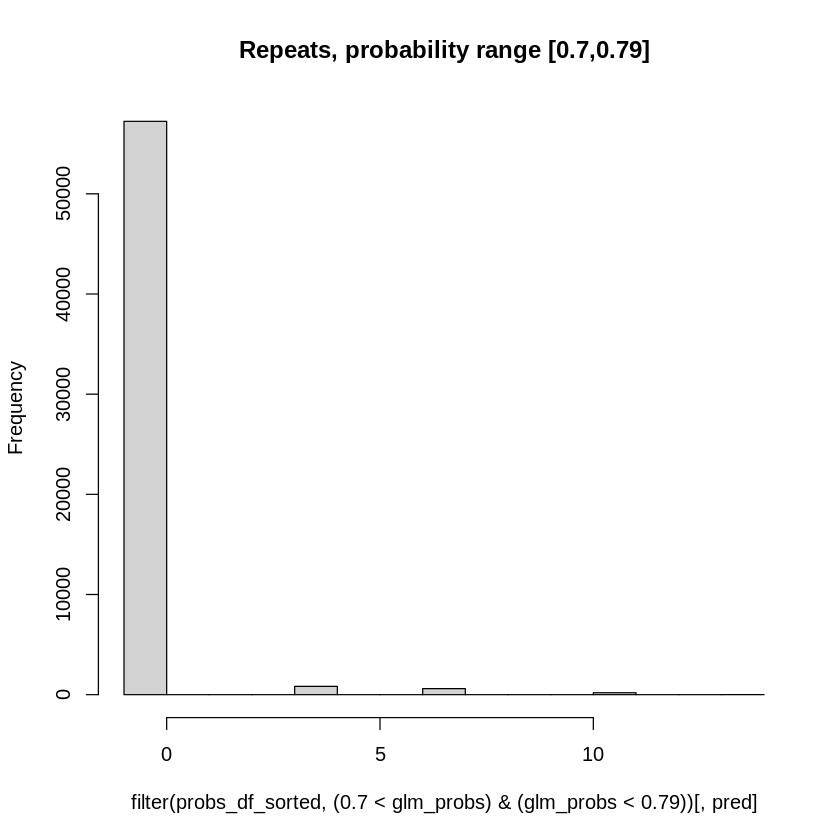

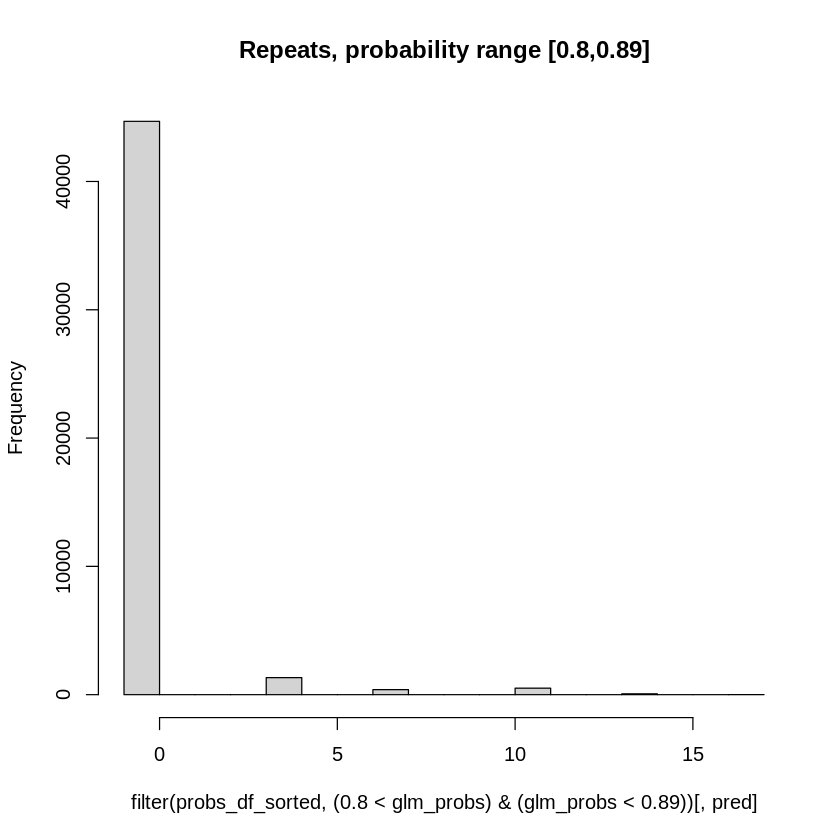

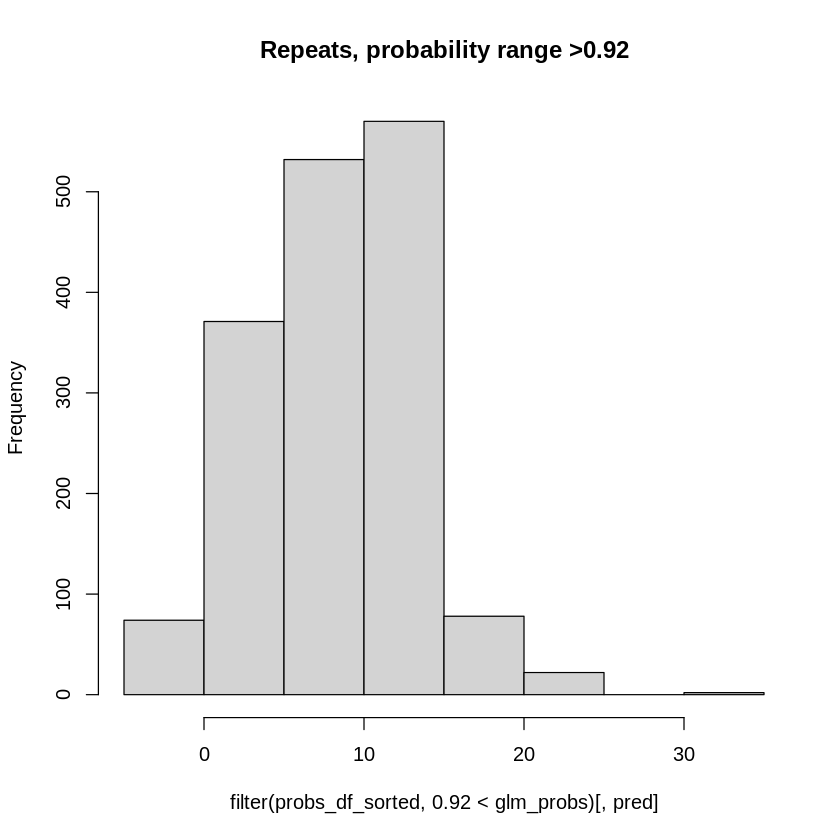

In [69]:
pred='Repeats.1'
hist(filter(probs_df_sorted, (0.7<glm_probs)&(glm_probs<0.79))[,pred], main="Repeats, probability range [0.7,0.79]")
hist(filter(probs_df_sorted, (0.8<glm_probs)&(glm_probs<0.89))[,pred], main="Repeats, probability range [0.8,0.89]")
hist(filter(probs_df_sorted, 0.92<glm_probs)[,pred], main="Repeats, probability range >0.92")

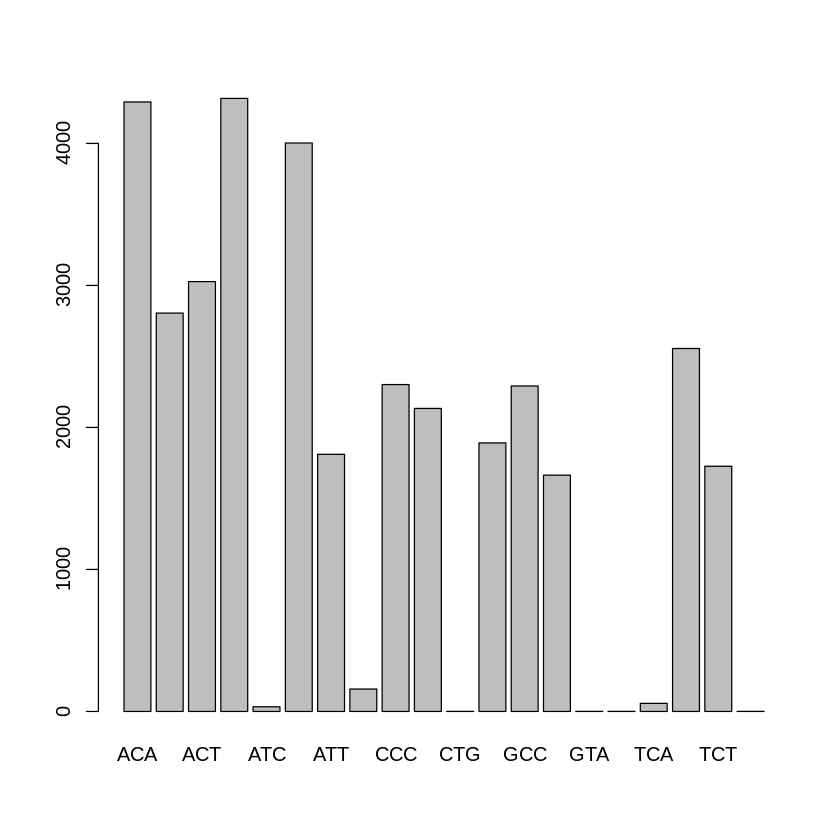

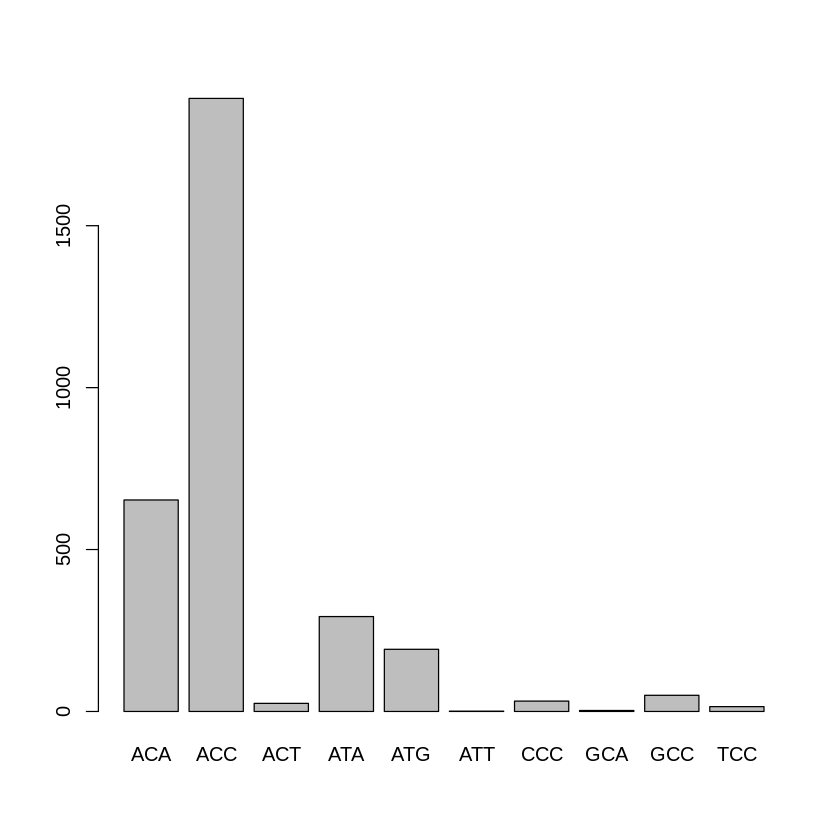

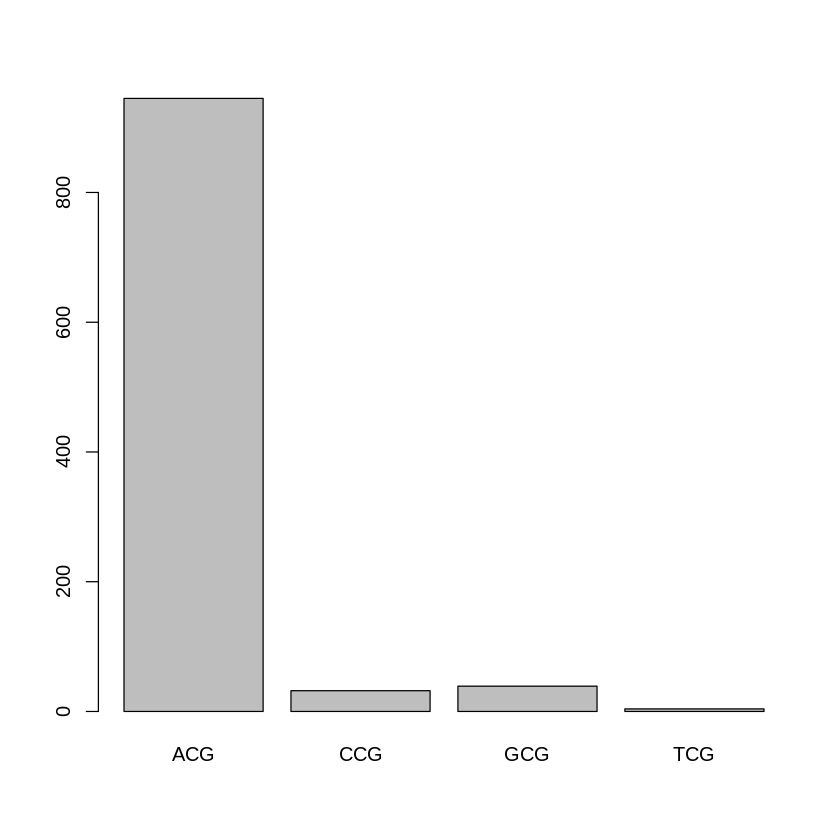

In [71]:
pred = "triplet"
barplot(table(filter(probs_df_sorted, (0.5<glm_probs)&(glm_probs<0.7))[,pred]))
barplot(table(filter(probs_df_sorted, (0.6<glm_probs)&(glm_probs<0.7))[,pred]))
barplot(table(filter(probs_df_sorted, (glm_probs>0.92))[,pred]))